# Logistic Falkon 1D data

In [3]:
import os
import sys

import time
import torch
import numpy as np
from sklearn import datasets, model_selection, metrics
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import falkon
from datetime import datetime

# sys.path.insert(0, "../data")
from plot_utils import plot_ref_data, plot_ref_data_reco, plot_loss_history, plot_one_t, plot_two_t



In [4]:
from falkon import LogisticFalkon
from falkon.kernels import GaussianKernel
from falkon.options import FalkonOptions
from falkon.gsc_losses import WeightedCrossEntropyLoss

## Define class

In [ ]:
def normalize(X):
    """Standardize dataset
    Args:
        X (np.ndarray): Original Dataset
    Returns:
        np.ndarray: Normalized Dataset
    """    
    X_norm = X.copy()
    
    for j in range(X_norm.shape[1]):
        column = X_norm[:, j]

        mean = np.mean(column)
        std = np.std(column)
    
        if np.min(column) < 0:
            column = (column-mean)*1./ std
        elif np.max(column) > 1.0:                                                                                                                                        
            column = column *1./ mean
    
        X_norm[:, j] = column
    
    return X_norm
    

def normalize_features(reference, data):
    """
    Normalize features (higgs normalization)

    Parameters
    ----------
    reference : np.ndarray
        Numpy array reference sample
    data : np.ndarray
        Numpy array data sample

    Returns
    -------
    ref_norm : np.ndarray
        Normalized Numpy array reference sample
    data_norm : np.ndarray
        Normalized Numpy array data sample

    """
    
    X_norm = normalize(np.vstack((reference, data)))
    
    ref_size = reference.shape[0]
    
    ref_norm = X_norm[:ref_size, :]
    data_norm = X_norm[ref_size:, :]
    
    return ref_norm, data_norm

def generate_data(N_REF, N_BKG, N_SIG, SIG_LOC, SIG_STD, normalize=False):
    """Generate synthetic data for training and testing a machine learning model.

    Args:
        config_json (dict): A dictionary containing the configuration parameters for generating the data.

    Returns:
        tuple: A tuple containing the feature tensor and target tensor.
            The feature tensor has shape (N_samples, N_features) and contains the input features for each sample.
            The target tensor has shape (N_samples, 2) and contains the target labels and weights for each sample.
    """
    
    # poisson fluctuate the number of events in each sample
    N_bkg_p = int(torch.distributions.Poisson(rate=N_BKG).sample())
    N_sig_p = int(torch.distributions.Poisson(rate=N_SIG).sample())
    
    # the reference rate will not have nuisance parameters
    feature_ref_dist = torch.distributions.Exponential(rate=1)

    # the data rate will have nuisance parameters   
    feature_bkg_dist = torch.distributions.Exponential(rate=1)
    feature_sig_dist = torch.distributions.Normal(loc=SIG_LOC, scale=SIG_STD)
    
    # generate the features
    feature_ref  = feature_ref_dist.sample((N_REF, 1))
    feature_data = torch.cat(
        (
            feature_bkg_dist.sample((N_bkg_p, 1)),
            feature_sig_dist.sample((N_sig_p, 1))
        )
    )

    # concatenate the features
    feature = torch.cat((feature_ref, feature_data), dim=0)

    # generate the target
    target_ref  = torch.zeros((N_REF, 1))
    target_data = torch.ones((N_bkg_p + N_sig_p, 1))

    target = torch.cat((target_ref, target_data), dim=0)
    
    # if normalize:
    #     feature = norm_func(feature)
 
    return feature_ref, target_data, target_ref, target_data

In [ ]:
class HEPModel_1D:
    """
    Generic model
    """

    def __init__(self, model_params, data_params):
    # def __init__(self, N_REF, N_BKG, N_SIG, SIG_LOC, SIG_STD):
        """Create a model for HEP anomaly detection

        Args:
            reference_path (str): path of directory containing data used as reference data (set of .h5 files)
            data_path (str): path of directory containing data used as datasample (set of .h5 files)
            output_path (str): directory in which results will be stored (If the directory doesn't exist it will be created)
            norm_fun (Optional, Callable): function used to normalize data. It takes the reference and data samples (two numpy.ndarray) and returns two numpy.ndarray representing the normalized reference and data samples (default to Higgs normalization)
        """
        self.model   = None
        self.N_REF   = data_params["N_REF"]
        self.N_BKG   = data_params["N_BKG"]
        self.N_SIG   = data_params["N_SIG"]
        self.SIG_LOC = data_params["SIG_LOC"]
        self.SIG_STD = data_params["SIG_STD"]
        
        self.sigma = model_params["sigma"]
        self.penalty_list = model_params["penalty_list"]
        self.iter_list = model_params["iter_list"]
        self.M = model_params["M"]
        self.keops = model_params["keops_active"]
        self.seed = model_params["seed"]
        
    @property
    def model_seed(self):
        if self.model is not None:
            return self.model.seed
        raise Exception("Model is not built yet!")
    
    def generate_data(self, N_REF, N_BKG, N_SIG, SIG_LOC, SIG_STD, normalize=False):
        """Generate synthetic data for training and testing a machine learning model.

        Args:
            config_json (dict): A dictionary containing the configuration parameters for generating the data.

        Returns:
            tuple: A tuple containing the feature tensor and target tensor.
                The feature tensor has shape (N_samples, N_features) and contains the input features for each sample.
                The target tensor has shape (N_samples, 2) and contains the target labels and weights for each sample.
        """
        # poisson fluctuate the number of events in each sample
        N_bkg_p = int(torch.distributions.Poisson(rate=N_BKG).sample())
        N_sig_p = int(torch.distributions.Poisson(rate=N_SIG).sample())
        
        feature_ref_dist = torch.distributions.Exponential(rate=1)

        feature_bkg_dist = torch.distributions.Exponential(rate=1)
        feature_sig_dist = torch.distributions.Normal(loc=SIG_LOC, scale=SIG_STD)
        
        # generate the features
        feature_ref  = feature_ref_dist.sample((N_REF, 1))
        feature_data = torch.cat(
            (
                feature_bkg_dist.sample((N_bkg_p, 1)),
                feature_sig_dist.sample((N_sig_p, 1))
            )
        )

        # concatenate the features
        feature = torch.cat((feature_ref, feature_data), dim=0)

        # generate the target
        target_ref  = torch.zeros((N_REF, 1))
        target_data = torch.ones((N_bkg_p + N_sig_p, 1))

        target = torch.cat((target_ref, target_data), dim=0)
        

        return feature, target, feature_ref, feature_data, target_ref, target_data
    
    def build_model(self):
        kernel = GaussianKernel(torch.Tensor([self.sigma]))
        cg_tol = 1e-7
        keops_active = "no"
        use_cpu = False
        weight = self.N_BKG / self.N_REF
        configuration = {
            'kernel' : kernel,
            'penalty_list' : self.penalty_list,
            'iter_list' : self.iter_list,
            'M' : self.M,
            'options' : FalkonOptions(cg_tolerance=cg_tol, keops_active=keops_active, use_cpu=use_cpu, debug = False),
            'loss' : WeightedCrossEntropyLoss(kernel=kernel, neg_weight=weight),
            'seed' : self.seed
        }
        self.model = LogisticFalkon(**configuration)

    def predict(self, data):
        return self.model.predict(data)

    def fit(self, X, y):
        self.model.fit(X, y)

    def learn_t(self):   
            
        """Method used to compute the t values 

        Args:
            R (int): Size of the reference \(N_0\)
            B (int): Mean of the Poisson distribution from which the size of the background is sampled
            S (int): Mean of the Poisson distribution from which the size of the signal is sampled
            features (list[str]): List containing the name of the features used
            model_parameters (dict): Dictionary containing the parameters for the model used
            sig_type (int): Type of signal (0: no-signal, 1: resonant, 2: non-resonant).
            cut (int, optional): Cut MLL. Defaults to None.
            normalize (bool, optional): If True data will be normalized before fitting the model. Defaults to False.
            seeds (tuple[int, int], optional): A tuple (reference_seed, data_seed) used to generate reference and data sample, if None two random seeds are generated. Defaults to None.
            pred_features (list[str], optional): List of features to perform predictions. Defaults to None.

        """        
        random_seed = self.seed if self.seed is not None else np.random.randint(1000)
        
        
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)
        print(random_seed)

        feature, target, feature_ref, feature_data, target_ref, target_data = self.generate_data(self.N_REF, self.N_BKG, self.N_SIG, self.SIG_LOC, self.SIG_STD)
        
        # data = feature
  
        # Create and fit model
        weight = self.N_BKG / self.N_REF 
        self.build_model()

        Xtorch = feature
        Ytorch = target      

        train_time = time.time()
        self.fit(Xtorch, Ytorch)
        train_time = time.time() - train_time

        ref_pred, data_pred = self.predict(feature_ref), self.predict(feature_data)

        # Compute Nw and t
        # Nw = weight*torch.sum(torch.exp(ref_pred))
        diff = weight*torch.sum(1 - torch.exp(ref_pred))
        t = 2 * (diff + torch.sum(data_pred).item()).item()

        del data_pred, Xtorch, Ytorch
        return t, train_time#, ref_seed, data_seed#, ref_pred.numpy().reshape(-1)#ref_pred



    def save_result(self, fname, i, t, Nw, train_time, ref_seed, sig_seed):
        """Function which save the result of learn_t in a file

        Args:
            fname (str): File name in which the result will be stored (the file will be stored in the output path specified). 
            If the file already exists, the result will be appended. 
            i (int): Toy identifier
            t (float): value of t obtained
            Nw (float): Nw
            train_time (float): Time spent in fitting the model
            ref_seed (int): seed to reproduce the reference sample
            sig_seed (int): seed to reproduce the data sample
        """        
        with open(self.output_path + "/{}".format(fname), "a") as f:
            f.write("{},{},{},{},{},{},{}\n".format(i, t, Nw, train_time, ref_seed, sig_seed, self.model_seed))



In [ ]:
model_parameters = {
    'sigma' : 0.3, # kernel lengthscale
    'penalty_list' : [1e-7], # list of regularization parameters,
    'iter_list' : [1000], #list of number of CG iterations,
    'M' : 3000, #number of Nystrom centers,
    'keops_active': "pyKeOPS", # optional, if it is used, pyKeOPS is used to speed-up computations
    'seed' : None # (int or None), the model seed (used for Nystrom center selection) is manually set.
 }
data_params = {
    "N_REF"   : 200000,
    "N_BKG"   : 2000,
    "N_SIG"   : 0,
    "SIG_LOC" : 6.4,
    "SIG_STD" : 0.16,
}
kernel = GaussianKernel(torch.Tensor([model_parameters["sigma"]]))
cg_tol = 1e-7
keops_active = "auto"
use_cpu = False
weight = data_params["N_BKG"] / data_params["N_REF"]
configuration = {
    'kernel' : kernel,
    'penalty_list' : model_parameters["penalty_list"],
    'iter_list' : model_parameters["iter_list"],
    'M' : model_parameters["M"],
    'options' : FalkonOptions(cg_tolerance=cg_tol, keops_active=keops_active, use_cpu=use_cpu, debug = False),
    'loss' : WeightedCrossEntropyLoss(kernel=kernel, neg_weight=weight),
    'seed' : model_parameters["seed"]
}

model = HEPModel_1D(model_parameters, data_params)
model

In [ ]:
t, _ = model.learn_t()
print(t)

135


Iteration 0 - penalty 1.000000e-07 - sub-iterations 1000


KeyboardInterrupt: 

In [ ]:
toys = 100
t_list = []

for toy in range(toys):
    t, _ = model.learn_t()
    t_list.append(t)
    

188
Iteration 0 - penalty 1.000000e-07 - sub-iterations 1000


KeyboardInterrupt: 

(array([0.10251464, 0.10983712, 0.12448207, 0.04393485, 0.0292899 ,
        0.05125732, 0.10251464, 0.08054722, 0.05125732, 0.03661237]),
 array([24.22436142, 25.59001999, 26.95567856, 28.32133713, 29.6869957 ,
        31.05265427, 32.41831284, 33.78397141, 35.14962997, 36.51528854,
        37.88094711]),
 <BarContainer object of 10 artists>)

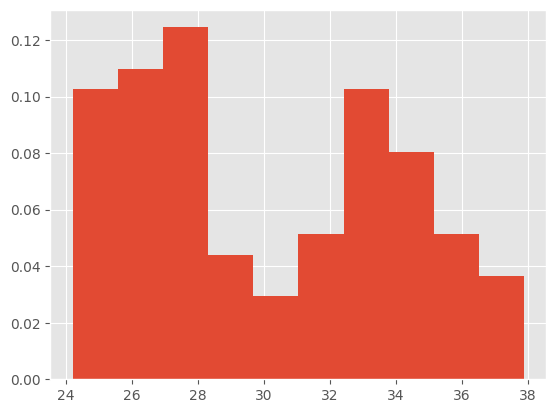

In [ ]:
plt.hist(t_list, density=True)

## HEPMODEL

In [5]:
from scipy import stats
import mplhep as hep
hep.style.use(hep.style.CMS)

sys.path.insert(0, "nn_models")
from LogFalkonHep import LogFalkonHEPModel

In [22]:
model_parameters = {
    'sigma' : 2.2, # kernel lengthscale
    'penalty_list' : [1e-10], # list of regularization parameters,
    'iter_list' : [10_000], #list of number of CG iterations,
    'M' : 3000, #number of Nystrom centers,
    'keops_active': "no", # optional, if it is used, pyKeOPS is used to speed-up computations
    'seed' : None, # (intor None), the model seed (used for Nystrom center selection) is manually set.
    'cg_tol' : np.sqrt(1e-5), # CG tolerance
    'use_cpu' : False # if falkon will be executed in cpu (optional, default False)
 }

data_params = {
    "N_REF"   : 200000,
    "N_BKG"   : 2000,
    "N_SIG"   : 0,
    "SIG_LOC" : 6.4,
    "SIG_STD" : 0.16,
}

In [23]:
model = LogFalkonHEPModel(data_params)

In [24]:
t, x, y = model.learn_t(model_parameters)
print(t)

Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
4.7625885009765625


In [25]:
toys = 30
t_list = []

for toy in range(toys):
    model_parameters['seed'] = np.random.randint(low=0, high=2**32, dtype=int)
    t, _, _ = model.learn_t(model_parameters)
    t_list.append(t)
    print(model.model_seed)

Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
588184108
Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
52129783
Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
3974719078
Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
3227915583
Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
3342167811
Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
2927894788
Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
2691171312
Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
517704124
Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
2153514908
Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
3642335837
Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
854016090
Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
1671634492
Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
1229536273
Iteration 0 - penalty 1.000000e-10 - sub-iterations 10000
3203683946
Iteration 0 - penalty 1.000000e-10 - su

In [26]:
# t_final = [t_list[i][0] for i in range(len(t_list))]

In [37]:
t_ref_bins  = np.arange(0, 40, 3)
t_data_bins = np.arange(0, 40, 3)
xgrid_ref   = np.arange(0, 40, 0.5)
xgrid_data  = np.arange(0, 40, 0.5)

ref_dof  = 9
ref_chi2 = stats.chi2(df=ref_dof)

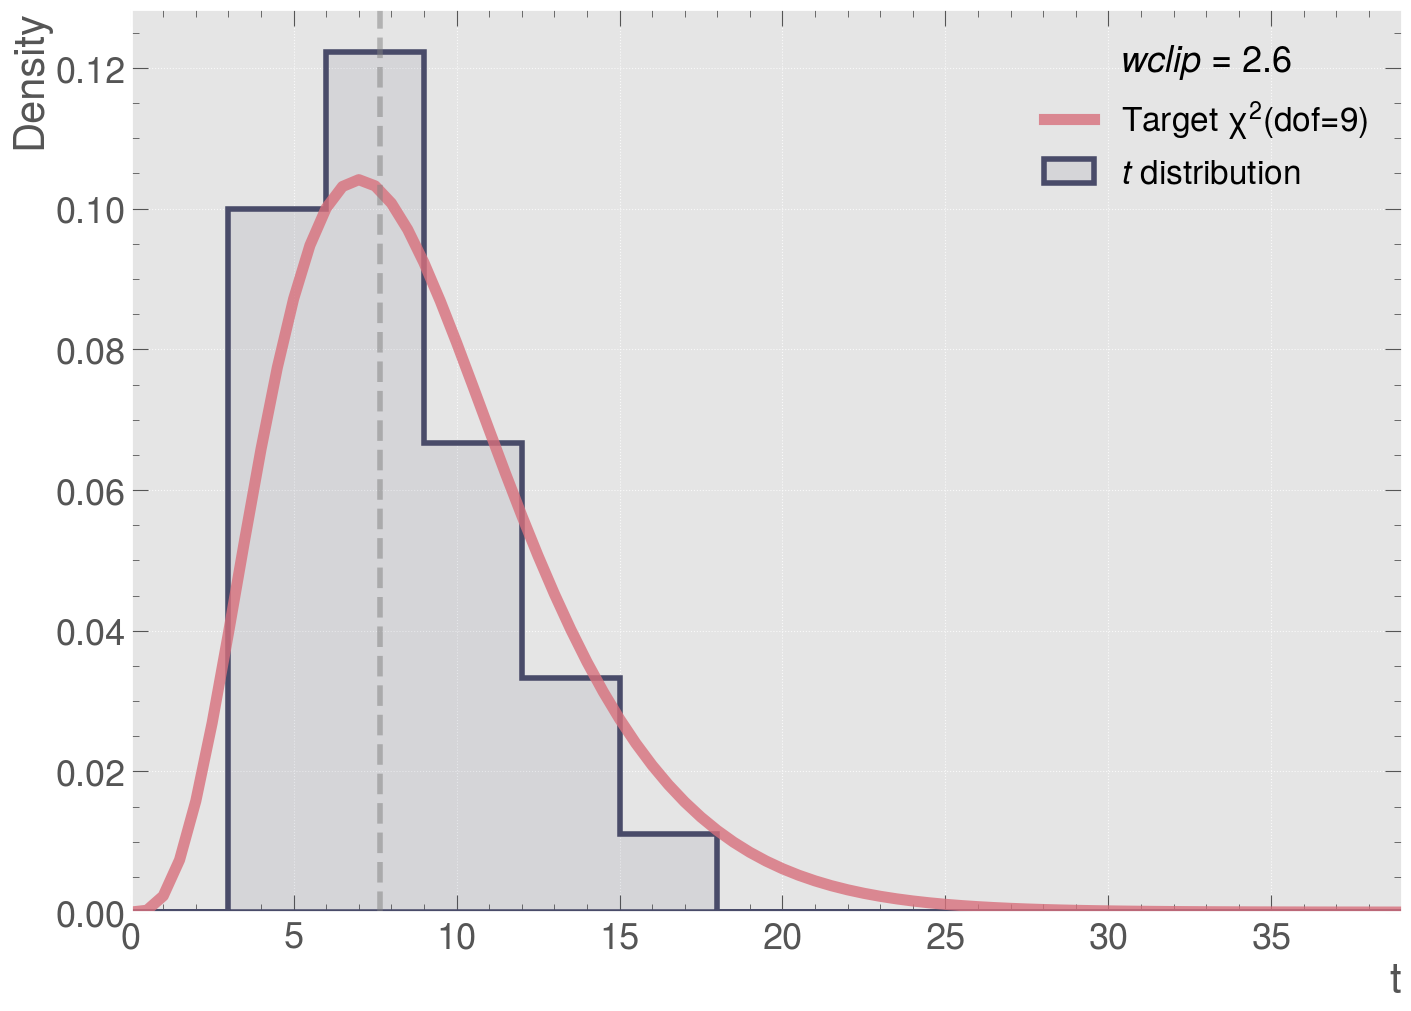

In [38]:
plot_one_t(
    t_distribution  = t_list,
    t_bins          = t_ref_bins,
    chi2            = ref_chi2,
    chi2_grid       = xgrid_ref,
    show_hist       = True,
    show_error      = False,
    compute_rate    = False,
    err_marker      = "o",
    err_markersize  = 10,
    err_capsize     = 5,
    err_elinewidth  = 4,
    err_capthick    = 4,
    err_color       = "black",
    figsize         = (14, 10),
    fontsize        = 30,
    cms             = False,
    cms_label       = "",
    cms_rlabel      = "",
    hist_ecolor     = ("#494B69", 1.0),
    hist_fcolor     = ("#494B69", 0.1),
    chi2_color      = ("#D8707C", 0.8),
    hist_lw         = 4,
    chi2_lw         = 8,
    hist_type       = "stepfilled",
    hist_label      = "$\it{t}$ distribution",
    chi2_label      = "Target $\chi^2$(dof=%i)"%(ref_dof),
    xlabel          = r"$t$",
    ylabel          = "Density",
    show_plot       = True,
    save_plot       = False,
    plot_name       = "t_distribution",
    # plot_path       = PLOT_PATH,
    plot_format     = "png",
    return_fig      = False,
    plot_w          = True,
    wclip           = 2.6,
)


## pairwise distance

In [29]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances

print(x.min())
data  = x[range(20_000)]
label = y[range(20_000)]


tensor(3.6615e-06)


In [30]:
distances = pairwise_distances(data, metric='l2')

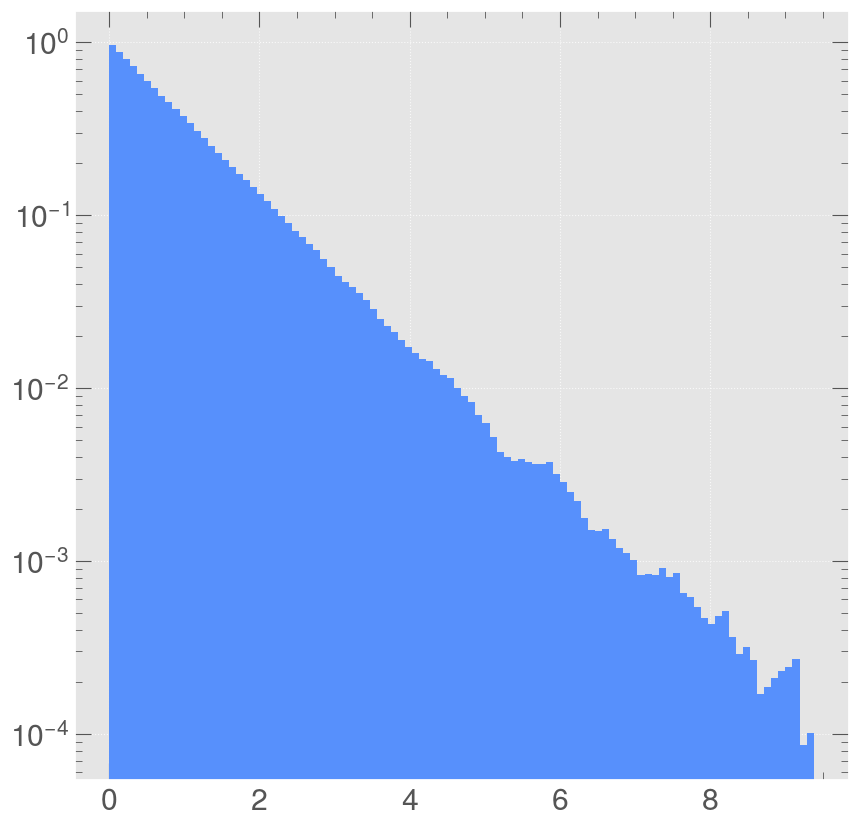

In [20]:
plt.hist(distances.ravel(), bins=100, density=True)
plt.yscale('log')
plt.show()

In [21]:
print(np.quantile(distances, 0.90))
print(np.median(distances))

2.2797062397003174
0.6832736
